It is another model constructed for same problem. First version was a SGDClassifier with 1 million data. This version will be a Boosting Algorithm, XGBoost, to compare. Most of the code will be same, only algorithm section and feature engineering section will be different. 

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns',25)
import random

p = 0.001
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')
click = pd.read_csv(r'C:\Users\ali.kilinc\Desktop\CTR Prediction\avazu-ctr-prediction\train\train.csv', 
                    index_col= False, parse_dates = ['hour'], date_parser = parse_date, skiprows = lambda i: i>0 and random.random() > p)

Above code mainly about importing csv file, randomly coosing rows from 40 million dataset. It assigns random values to each row, and skips the rows above that threshold probability. In this example, it is 0.001 which leads to a randomly chosen 40000 dataset. Randomization is required to preserve the distributions inside dataset.

In [2]:
print(click.info())
print(click.describe(include='all'))
print(click.columns)
print(click.head(5))
print(click.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40481 entries, 0 to 40480
Data columns (total 24 columns):
id                  40481 non-null uint64
click               40481 non-null int64
hour                40481 non-null datetime64[ns]
C1                  40481 non-null int64
banner_pos          40481 non-null int64
site_id             40481 non-null object
site_domain         40481 non-null object
site_category       40481 non-null object
app_id              40481 non-null object
app_domain          40481 non-null object
app_category        40481 non-null object
device_id           40481 non-null object
device_ip           40481 non-null object
device_model        40481 non-null object
device_type         40481 non-null int64
device_conn_type    40481 non-null int64
C14                 40481 non-null int64
C15                 40481 non-null int64
C16                 40481 non-null int64
C17                 40481 non-null int64
C18                 40481 non-null int64
C19        

In [3]:
click.groupby('click').size().plot(kind = 'bar')

click_through_rate = click['click'].value_counts()/click.shape[0]

print(click_through_rate)
# graph showing the target value distribution, which shows that it is a slghtly unbalanced data(0.82/0.18 rate)

0    0.829772
1    0.170228
Name: click, dtype: float64


In [4]:
click['hour_in_day'] = click['hour'].apply(lambda val : val.hour)

click['weekday'] = click['hour'].apply(lambda val: val.dayofweek)

#click['day_name'] = click['hour'].apply(lambda x: x.strftime('%A'))
# Hour feature is divided into various features that may be beneficial if analyzed seperately like weekday and hour in day.

In [5]:
click = click.drop(['id', 'hour', 'device_id', 'device_ip'], axis = 1)

print(click.columns)

Y = click.iloc[:,:1]
ycol = click.columns[:1]
df_y = pd.DataFrame(Y, columns = ycol)

X = click.drop(['click'], axis = 1)
xcol = click.columns[1:]
df_x = pd.DataFrame(X, columns = xcol)

#Some of the features whch are too personal are eliminated initially. ID, device ID, and Device IP are too special values to analyze
#Also hour feature is eliminated because it is divided into seperate features

Index(['click', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category',
       'app_id', 'app_domain', 'app_category', 'device_model', 'device_type',
       'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'hour_in_day', 'weekday'],
      dtype='object')


In [6]:
unique_counts = pd.DataFrame.from_records([(col, df_x[col].nunique()) for col in df_x.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])
print(unique_counts)

fix_cols = []
for col in df_x.columns:
    if df_x[col].nunique() == 1:
        fix_cols.append(col)
    else:
        pass

emp_cols = []
for col in df_x.columns:
    if df_x[col].count() > 0:
        pass
    else:
        emp_cols.append(col)
        
df_x.drop(list(emp_cols+fix_cols))

for col in df_x.columns:
    df_x[col] = df_x[col].astype('category')

#Empty and fix columns are eliminated with above code. Also we see the unique values for each features, to see which features 
# may lead us to curse of dimensionality. Some feature engineering may be needed afterwards. 

print(df_x.groupby('device_model').filter(lambda x: len(x) <5)['device_model'])
df_x['device_model'] = df_x['device_model'].replace(df_x.groupby('device_model').filter(lambda x: len(x) <5)['device_model'], 'oth')
print(df_x['device_model'].value_counts())

#df_x['C14'] = df_x['C14'].replace(df_x.groupby('C14').filter(lambda x: len(x) <5)['C14'], 'oth2')
#print(df_x['C14'].value_counts())

df_x['site_id'] = df_x['site_id'].replace(df_x.groupby('site_id').filter(lambda x: len(x) <5)['site_id'], 'oth3')
print(df_x['site_id'].value_counts())

for col in df_x.columns:
    df_x[col] = df_x[col].astype('category')

         Column_Name  Num_Unique
10  device_conn_type           4
15               C18           4
9        device_type           4
0                 C1           7
20           weekday           7
1         banner_pos           7
12               C15           8
13               C16           9
4      site_category          17
7       app_category          19
19       hour_in_day          24
18               C21          59
16               C19          64
6         app_domain          76
17               C20         149
14               C17         383
5             app_id         904
3        site_domain         917
2            site_id        1079
11               C14        1441
8       device_model        2403
2        96b83ebe
23       122187b6
27       a1f6d51e
31       4011970b
41       f50d4405
57       0ccaa0a9
67       351d0410
89       b351e2d6
113      1277f67f
126      4af5f36a
129      c3825bbb
150      267a9678
152      b353797d
153      80fdc835
156      aa7b9f66
184 

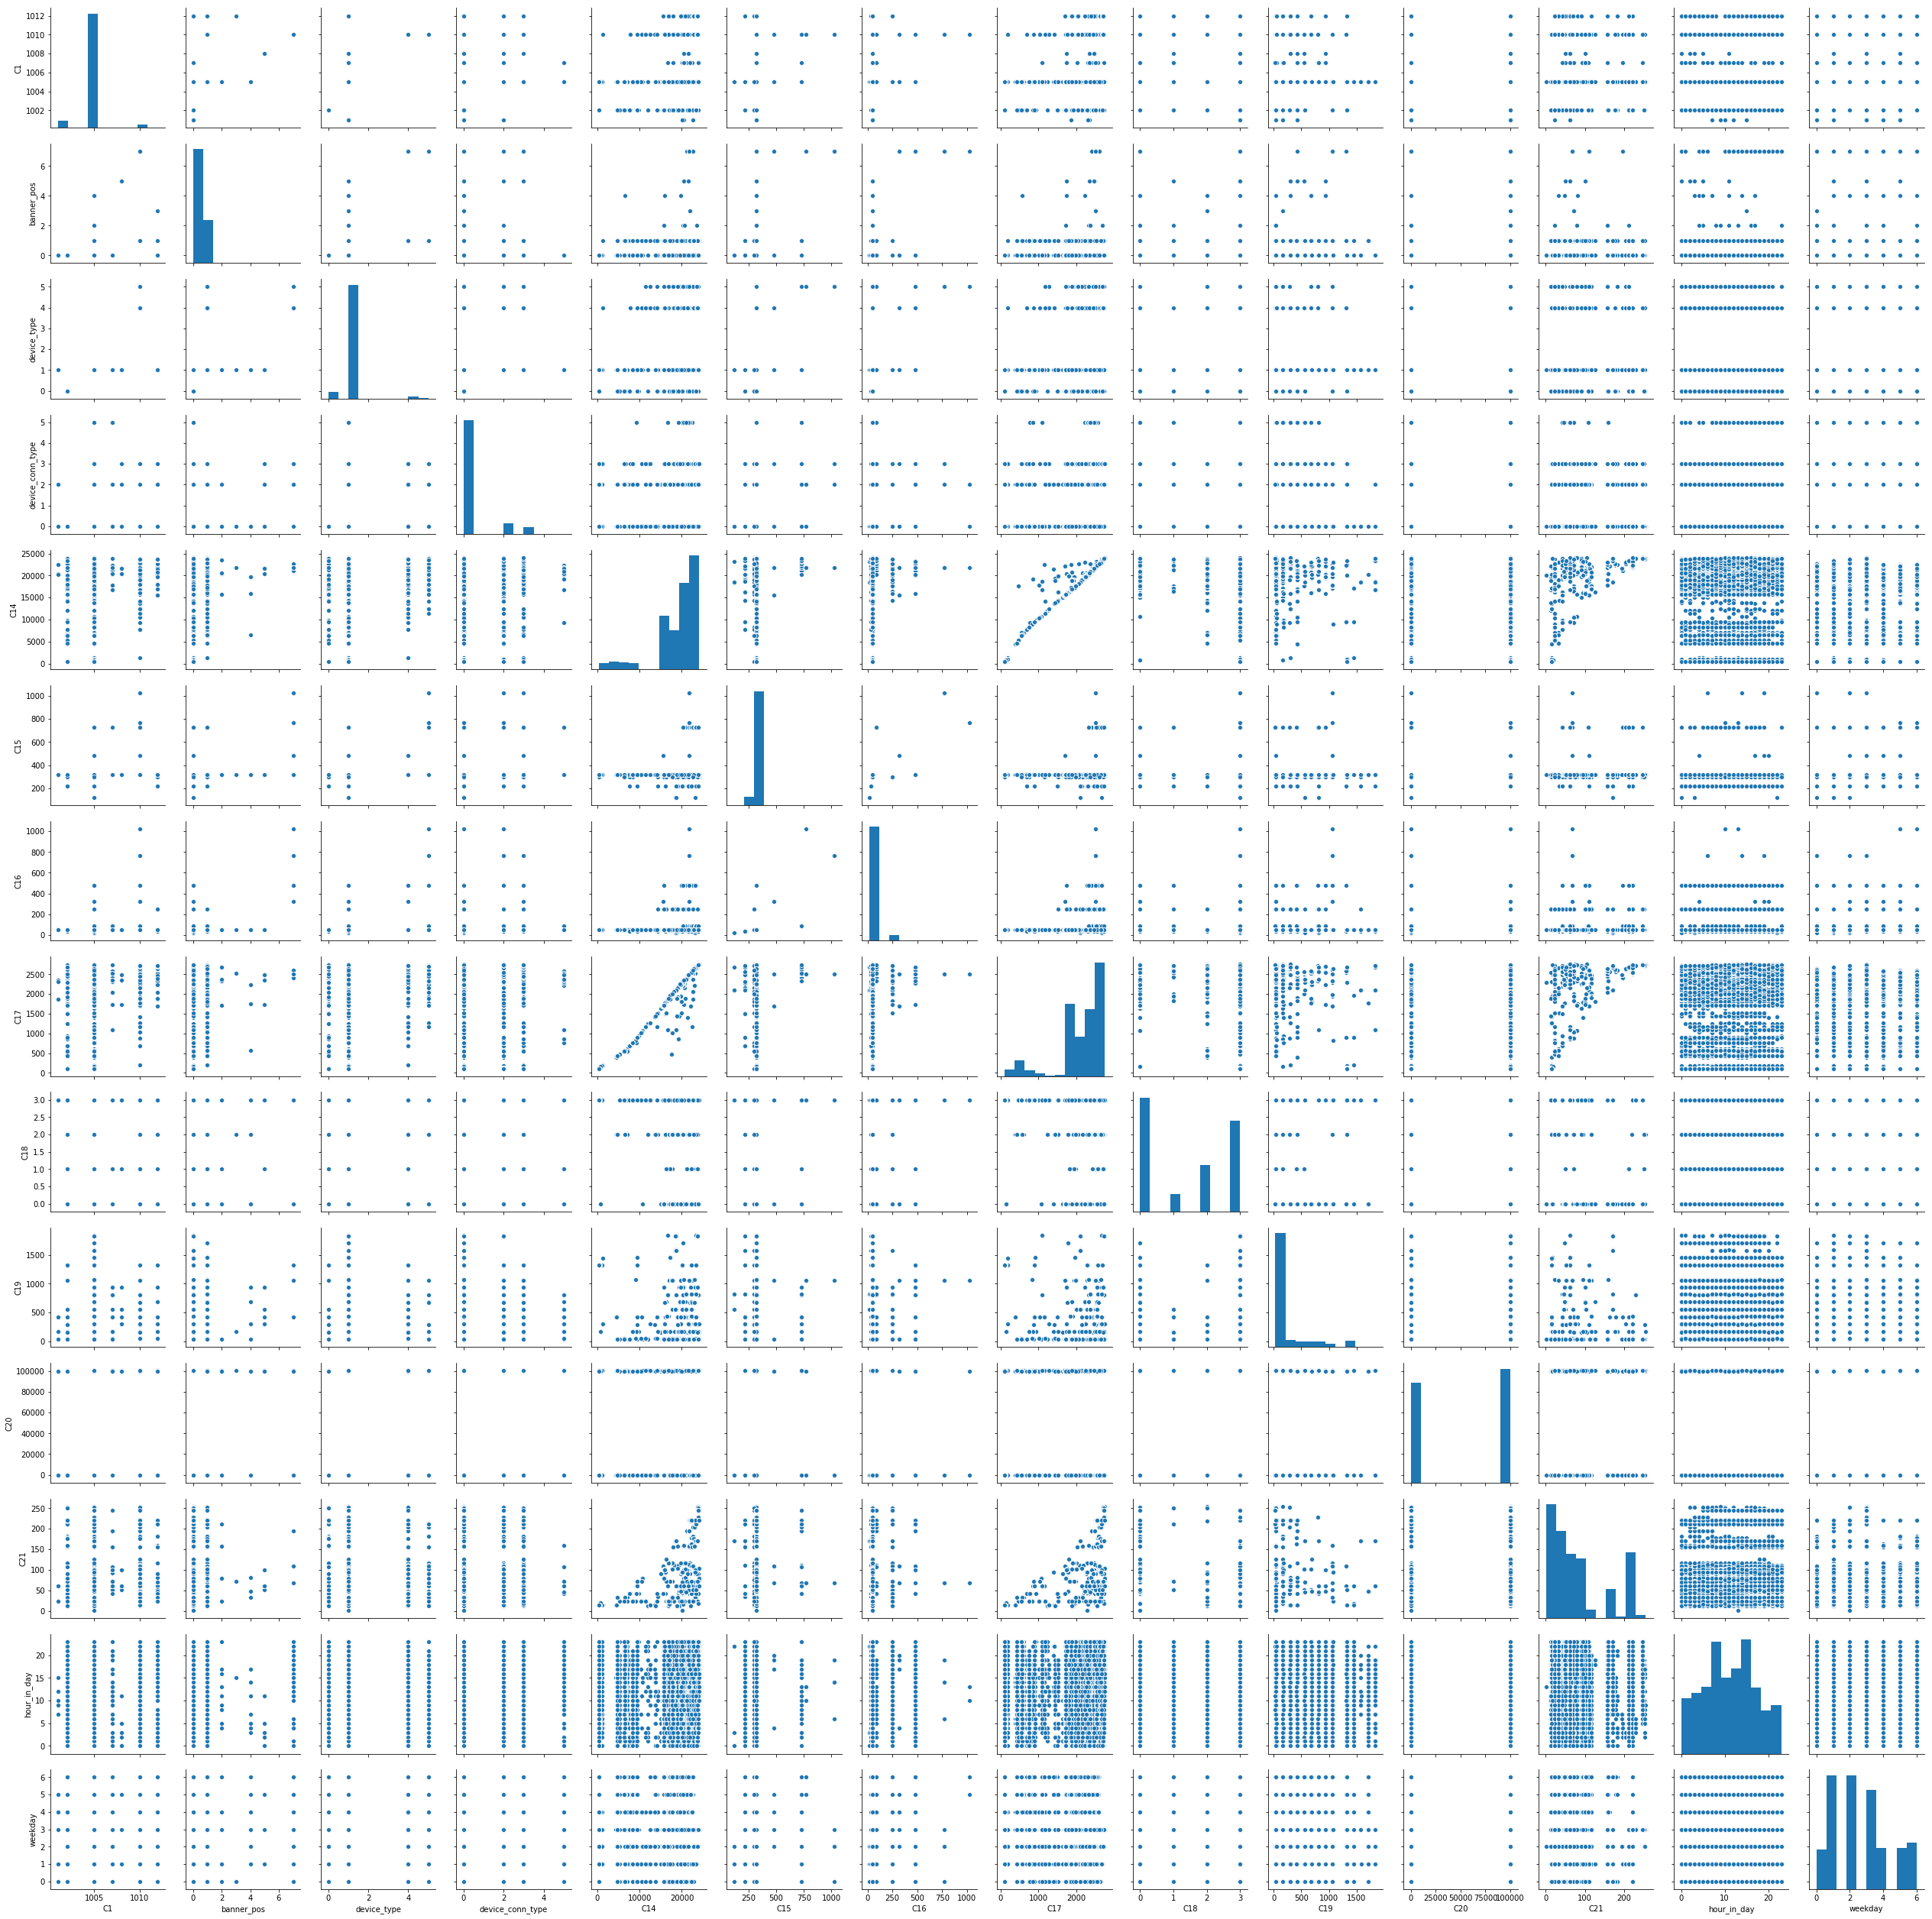

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df_x)

In [8]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, CategoricalEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier

In [9]:
import timeit
start_time = timeit.default_timer()

gbm = XGBClassifier(objective = 'binary:logistic', eval_metric = 'auc',  seed = 23, learning_rate = 0.01)


params = {
        'n_estimator': np.linspace(100,500,2,endpoint = True),
        'max_depth': np.linspace(3,15,3, endpoint=True, dtype = int),
        'min_child_weight':np.linspace(1, 9, 3, endpoint=True),
        'colsample_bytree': np.linspace(0.3,0.5,3,endpoint =True)
        
        }

In [10]:
print("code_test")
grid_search = GridSearchCV(gbm, params, cv=3, verbose=1)

pipe = make_pipeline(OneHotEncoder(sparse = True, handle_unknown='ignore'), grid_search)

cv = StratifiedKFold(n_splits = 5, random_state = 23, shuffle = False)

roc_auc = cross_val_score(pipe, df_x, df_y.values.ravel(), scoring = 'roc_auc', cv=cv)
accuracy = cross_val_score(pipe, df_x, df_y.values.ravel(), scoring = 'accuracy', cv=cv)

print("---%0.1f minutes---" %((timeit.default_timer()-start_time)/60))
print("roc_auc = {}, accuracy = {}".format(np.mean(roc_auc),np.mean(accuracy)))

code_test
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed: 15.1min finished


Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed: 15.5min finished


Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed: 15.6min finished


Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed: 15.4min finished


Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed: 15.1min finished


Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed: 15.4min finished


Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed: 15.2min finished


Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed: 15.1min finished


Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed: 15.0min finished


Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed: 14.9min finished


---154.9 minutes---
roc_auc = 0.6944414891747106, accuracy = 0.8310812549028797


In SGD algorithm, it took about 60 minutes to get a result of 0.67 roc-auc and 0.77 accuracy with 1 million data. 

XGBoost is much slower than this algorithm, but regarding this problem it got better results. For 40.000 rows of data(1/25 of SGD algorithm), roc-auc score is 0.69 and accuracy is 0.83 here, runtime is 180 minutes which is 3 times of SGD runtime. 